In [1]:
import matplotlib
matplotlib.use('NbAgg')
from matplotlib import pyplot as plt
from matplotlib.widgets import Button
import numpy as np
from skimage.io import imread
from dmd.gui import DraggableRectangle, RoiDrawing
plt.ion()

In [2]:
calibration_image_fname = '/Users/bennettd/tmp/checkerboard.png'
calibration_image = imread(calibration_image_fname)

<IPython.core.display.Javascript object>


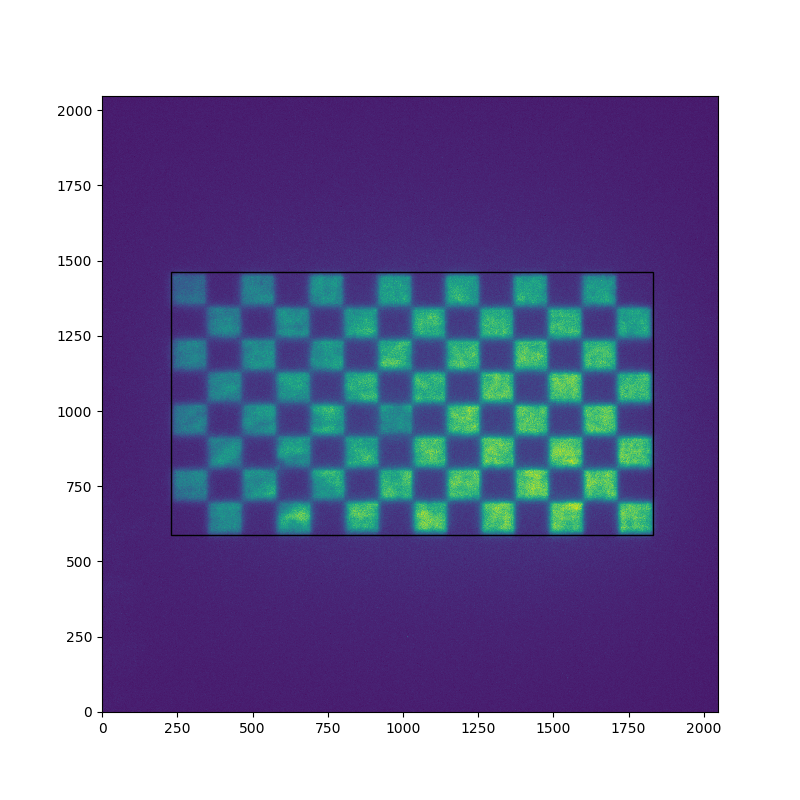

In [3]:
from matplotlib.patches import Rectangle
fig, axs = plt.subplots(figsize=(8,8))
axs.imshow(calibration_image, origin='lower')
x_guess, y_guess, w_guess, h_guess = 230, 588, 1600, 874
rect = Rectangle((x_guess,y_guess), w_guess, h_guess, fill=False)
axs.add_patch(rect)
dr = DraggableRectangle(rect)
dr.connect()
plt.show()

In [4]:
x, y, w, h = dr.rect.get_x(), dr.rect.get_y(), dr.rect.get_width(), dr.rect.get_height()
dmd_rect = [int(x), int(y), int(x + w), int(h + y)]

<IPython.core.display.Javascript object>


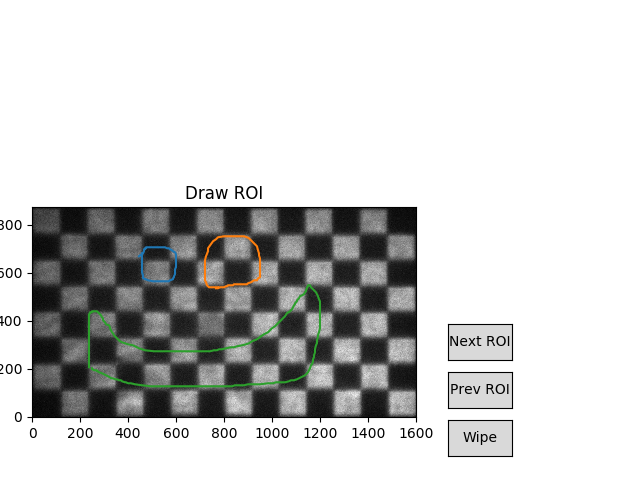

In [5]:
sample_image_fname = calibration_image_fname
sample_image = imread(sample_image_fname)

data = sample_image[dmd_rect[1]:dmd_rect[3],dmd_rect[0]:dmd_rect[2]]

fig = plt.figure()
ax = plt.axes([.05, .05, .6, .6])
ax.set_title('Draw ROI')
ax.imshow(data, cmap='gray', origin='lower')
#
roi_draw = RoiDrawing(ax, data)

ax_butt = plt.axes([0.7, 0.05, 0.1, 0.075])
wipe_butt = Button(ax_butt, 'Wipe')
wipe_butt.on_clicked(roi_draw.wipe)

ax_decr = plt.axes([.7, .15, .1, .075])
decr_button = Button(ax_decr, 'Prev ROI')
decr_button.on_clicked(roi_draw.focus_decr)

ax_incr = plt.axes([.7, .25, .1, .075])
incr_button = Button(ax_incr, 'Next ROI')
incr_button.on_clicked(roi_draw.focus_incr)
plt.show()

<IPython.core.display.Javascript object>


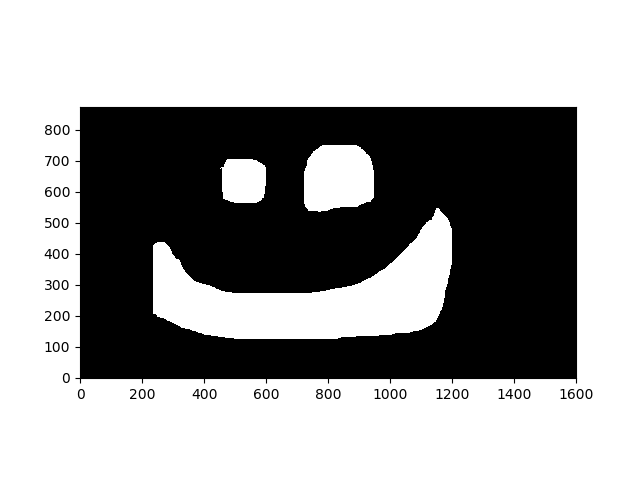

In [6]:
fig, axs = plt.subplots()
masks = np.array([r.get_mask() for r in roi_draw.rois])
plt.imshow(masks.sum(0), origin='lower', cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


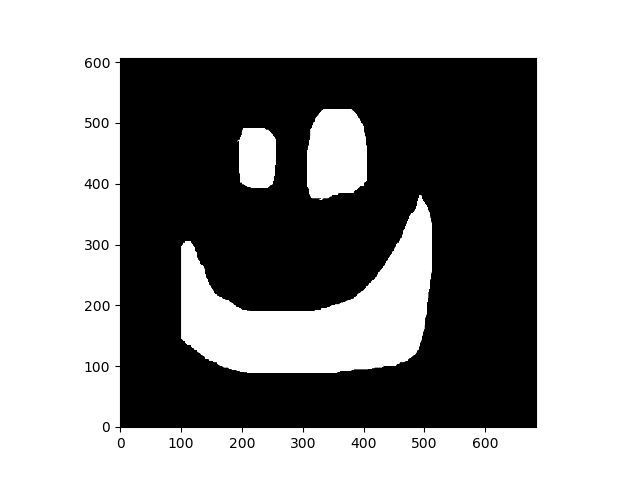

/Users/bennettd/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [7]:
# Apply transformations to ROI images and save to disk
from skimage.transform import resize
fig, axs = plt.subplots()
dmd_dims = (608,684)
plt.imshow(resize(masks.sum(0), output_shape = dmd_dims, mode='constant', cval=0), origin='lower',cmap='gray')
plt.show()